## Pytorch code percolation model with ResNet50

## initializations

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
seed=42
import torch
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed+1)

In [9]:
from __future__ import print_function, division
import os
print('torch version:',torch.__version__)
import sklearn
print('sklearn version:', sklearn.__version__)

torch version: 1.3.1
sklearn version: 0.22.1


In [33]:
import torchvision
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy

In [11]:
t=torch.Tensor()
print(t.dtype)
print(t.device)
print(t.layout)

torch.float32
cpu
torch.strided


In [12]:
device = torch.device("cuda:0") #switch to GPU
device

device(type='cuda', index=0)

## starting the main code

In [13]:
img_sizeX= 100
img_sizeY= 100 #img_sizeX
validation_split= 0.1

In [14]:
training_set=0
validation_set=0
path='../MachineLearning-Percolation/training_set_1000'
transform=torchvision.transforms.ToTensor() #transforms image to tensor

whole_dataset=torchvision.datasets.ImageFolder(root=path,
                                                   transform=transform)


In [15]:
data_size = len(whole_dataset)
validation_split=0.1
split=int(np.floor(validation_split*data_size))
training=int(data_size-split)
#split the data into training and validation
training_set, validation_set= torch.utils.data.random_split(whole_dataset,(training,split))
#Load data into batches 
train=torch.utils.data.DataLoader(training_set,batch_size=16,
                                          shuffle=True)

val=torch.utils.data.DataLoader(validation_set,batch_size=16 )

In [31]:
classes_names =whole_dataset.classes
classes_names

['no_percolation', 'percolation']

In [17]:
def imshow(inp, title=None):
    # torch convention gives [channel, height,width] but imshow gives [height,width,channel] hence the transpose
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(27,27))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated



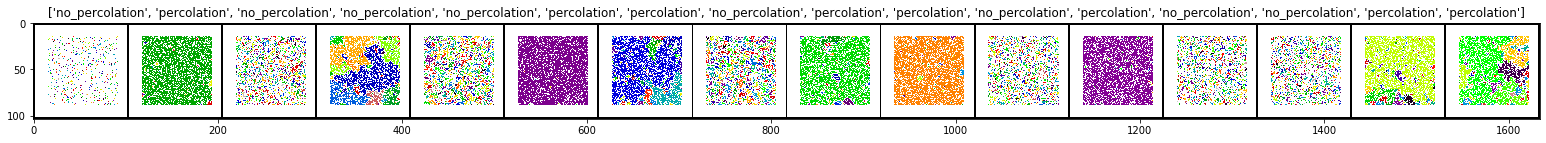

In [18]:
# Grab some of the training data to visualize
inputs, labels = next(iter(train))


# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=16)
#We plot all the images in one batch (here 16 images)
imshow(out, title=[class_names[x] for x in labels])


In [19]:
inputs.shape #batch size, channels, height, width

torch.Size([16, 3, 100, 100])

In [48]:
batch_size=16
num_of_train_samples = len(training_set) # total training samples
num_of_test_samples = len(validation_set) #total validation samples
number_classes = len(class_names)#number of classes
steps_per_epoch = np.ceil(num_of_train_samples // batch_size)
print(num_of_train_samples)
print(num_of_test_samples )
print(len(train)) 
print(len(val))
print(number_classes )

9000
1000
563
63
2


## building the CNN

In [49]:
model1=models.resnet50(pretrained=True, progress=True)

num_ftrs = model1.fc.in_features # number of input features of the last layer which is fully connected (fc)

#We modify the last layer in order to have 2 output: percolating or not
model1.fc=nn.Linear(num_ftrs, number_classes )
 #the model is sent to the GPU
model1 = model1.to(device)


In [50]:
model1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [51]:
lr=0.01
criterion = nn.CrossEntropyLoss() #Define the loss function
#optimizer_ft = torch.optim.Adam(model1.parameters(), lr=lr) 


optimizer_ft = torch.optim.SGD(model1.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)




In [52]:
def train_model(model,criterion, optimizer, num_epochs, scheduler, batch_size):
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-' * 10)
        
    #two phases training and validating
        for phase in [train,val]:
            if phase == train:
                model.train()# set the model to training mode
            else:
                model.eval() 
                
            running_loss=0.0
            running_corrects=0.0
            
            # Here's where the training happens
            print('Iterating through data...')
            
            for i, (inputs, labels) in enumerate(phase):
                inputs=inputs.to(device)
                labels=labels.to(device)
                
                
                #put the gradient to zero to avoid accumulation during back propagation
                optimizer.zero_grad()
                
                
                #now we need to carry out the forward and backward process in different steps
                #First the forward training
                #for the training step we need to log the loss
                with torch.set_grad_enabled(phase==train):
                    outputs=model(inputs)
                    _, preds= torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                
                #still for the training phase we need to implement backword process and optimization
                
                    if phase==train:
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                #loss.item() extract the loss value as float then it is multiply by the batch size
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+= torch.sum(preds==labels.data)
                
            if phase == train:
                scheduler.step()

                
            
            if phase ==train:
                epoch_loss= running_loss/len(phase.dataset)
                epoch_acc = running_corrects.double()/ len(phase.dataset)
                print('{} loss: {:4f} accuracy: {:4f}'.format(
                'training', epoch_loss, epoch_acc
            ))
                
            
            if phase==val:
                epoch_loss= running_loss/len(val.dataset)
                epoch_acc = running_corrects.double()/len(val.dataset)
                print('{} val_loss: {:4f} val_accuracy: {:4f}'.format(
            'validation:', epoch_loss, epoch_acc
            ))
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

                    
        

In [53]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [54]:
num_epochs=5
base_model = train_model(model1, criterion, optimizer_ft,num_epochs,exp_lr_scheduler,batch_size=16 )


Epoch 0/4
----------
Iterating through data...
training loss: 0.138352 accuracy: 0.940000
Iterating through data...
validation: val_loss: 0.095545 val_accuracy: 0.947000

Epoch 1/4
----------
Iterating through data...
training loss: 0.081340 accuracy: 0.965889
Iterating through data...
validation: val_loss: 0.105583 val_accuracy: 0.941000

Epoch 2/4
----------
Iterating through data...
training loss: 0.050785 accuracy: 0.981000
Iterating through data...
validation: val_loss: 0.137440 val_accuracy: 0.941000

Epoch 3/4
----------
Iterating through data...
training loss: 0.030451 accuracy: 0.988778
Iterating through data...
validation: val_loss: 0.135611 val_accuracy: 0.945000

Epoch 4/4
----------
Iterating through data...
training loss: 0.038289 accuracy: 0.988000
Iterating through data...
validation: val_loss: 0.149167 val_accuracy: 0.949000

Training complete in 2m 5s
Best val Acc: 0.949000


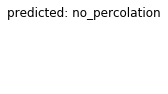

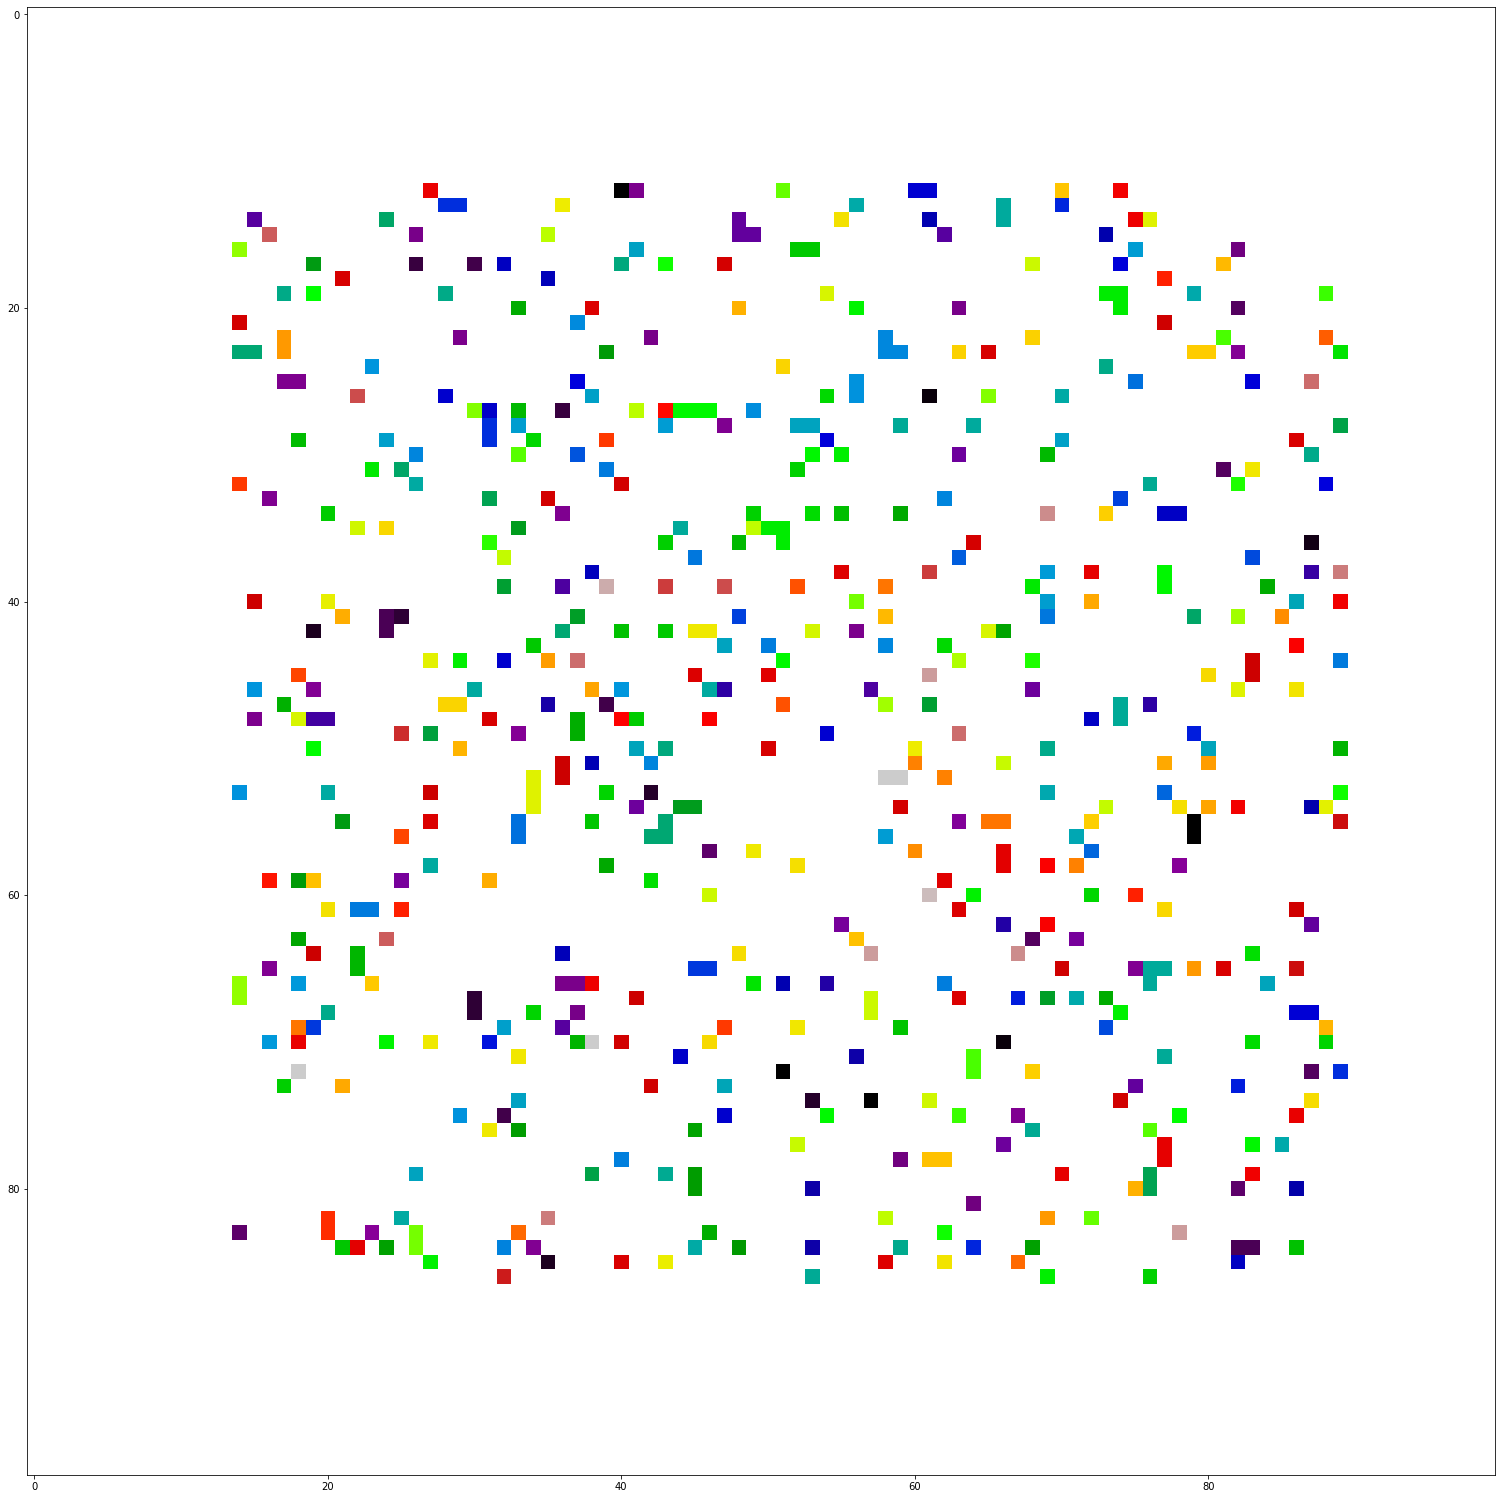

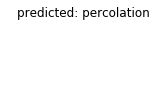

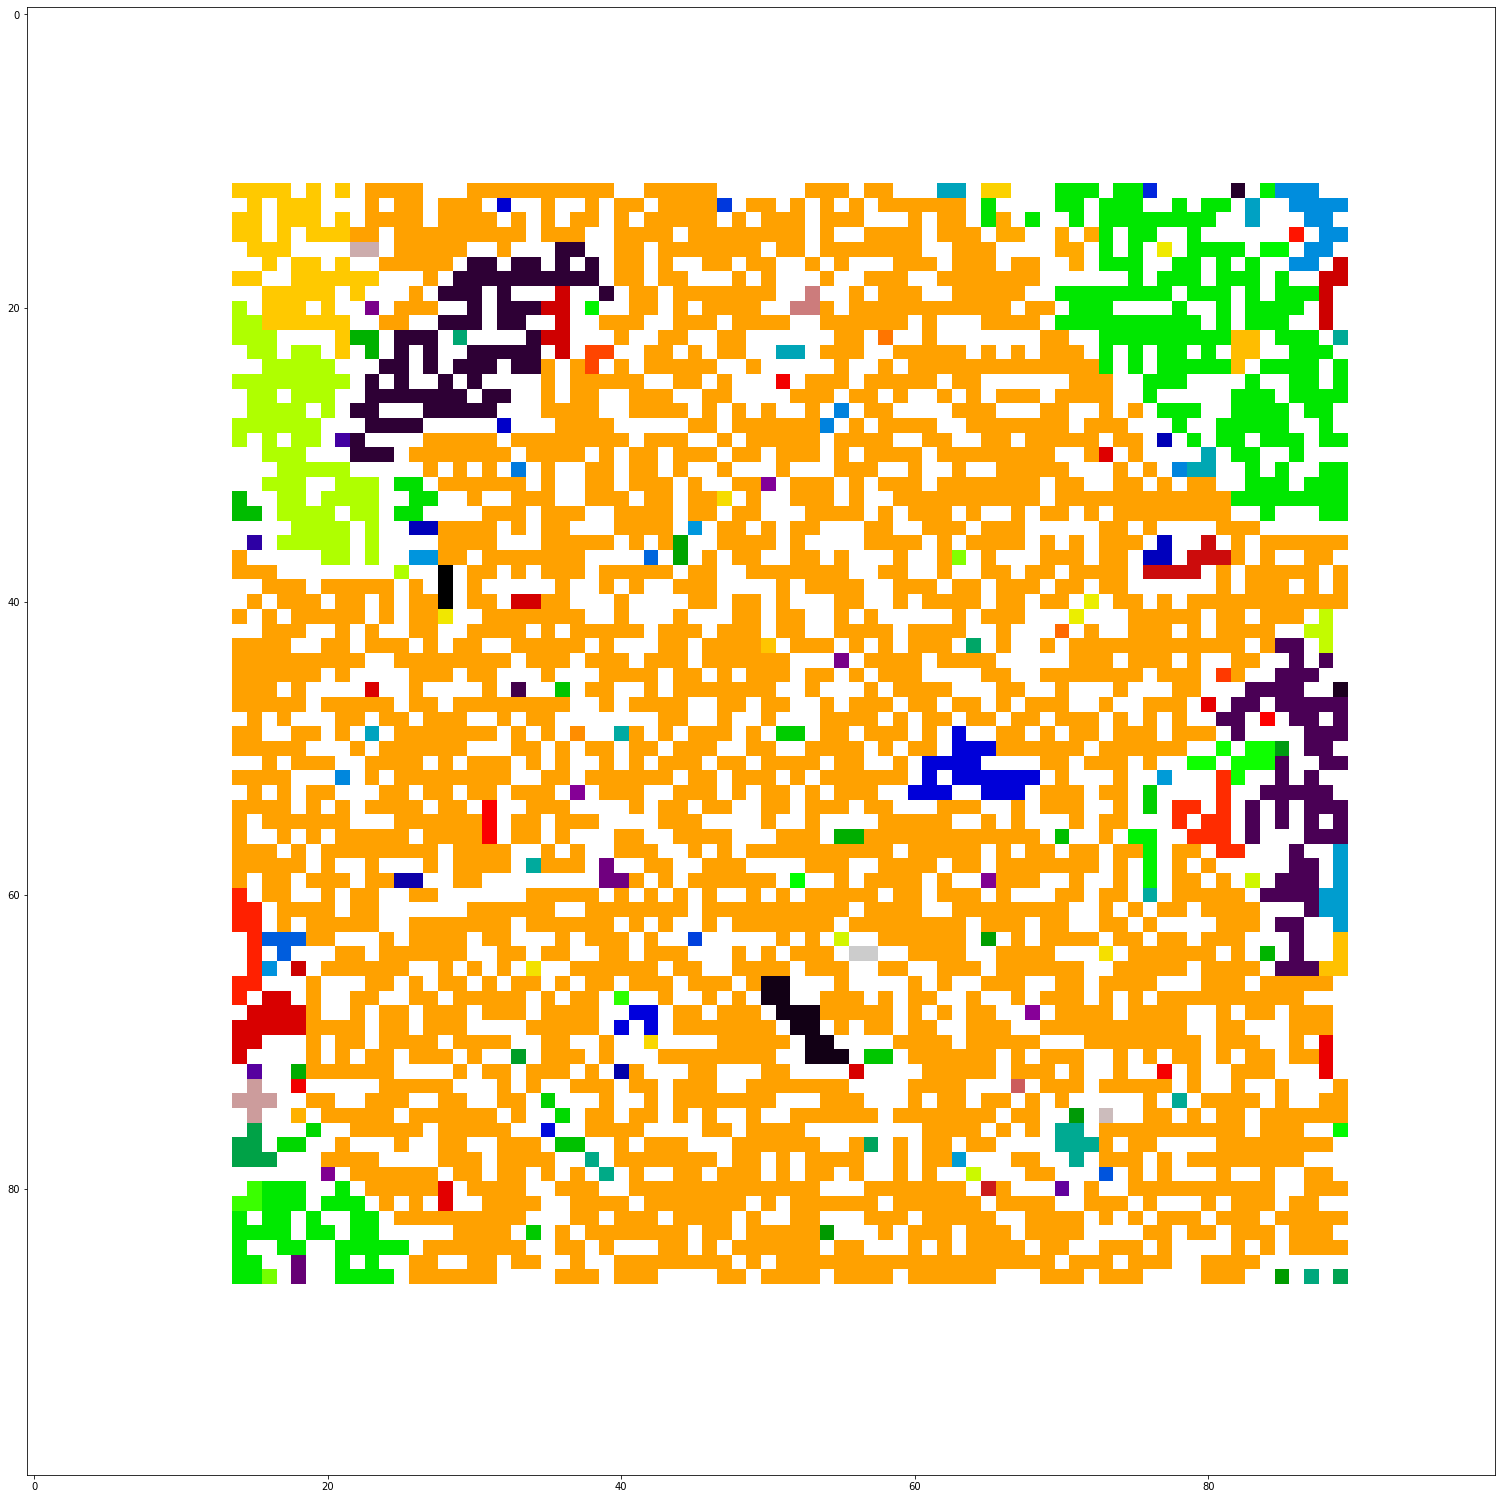

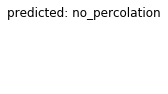

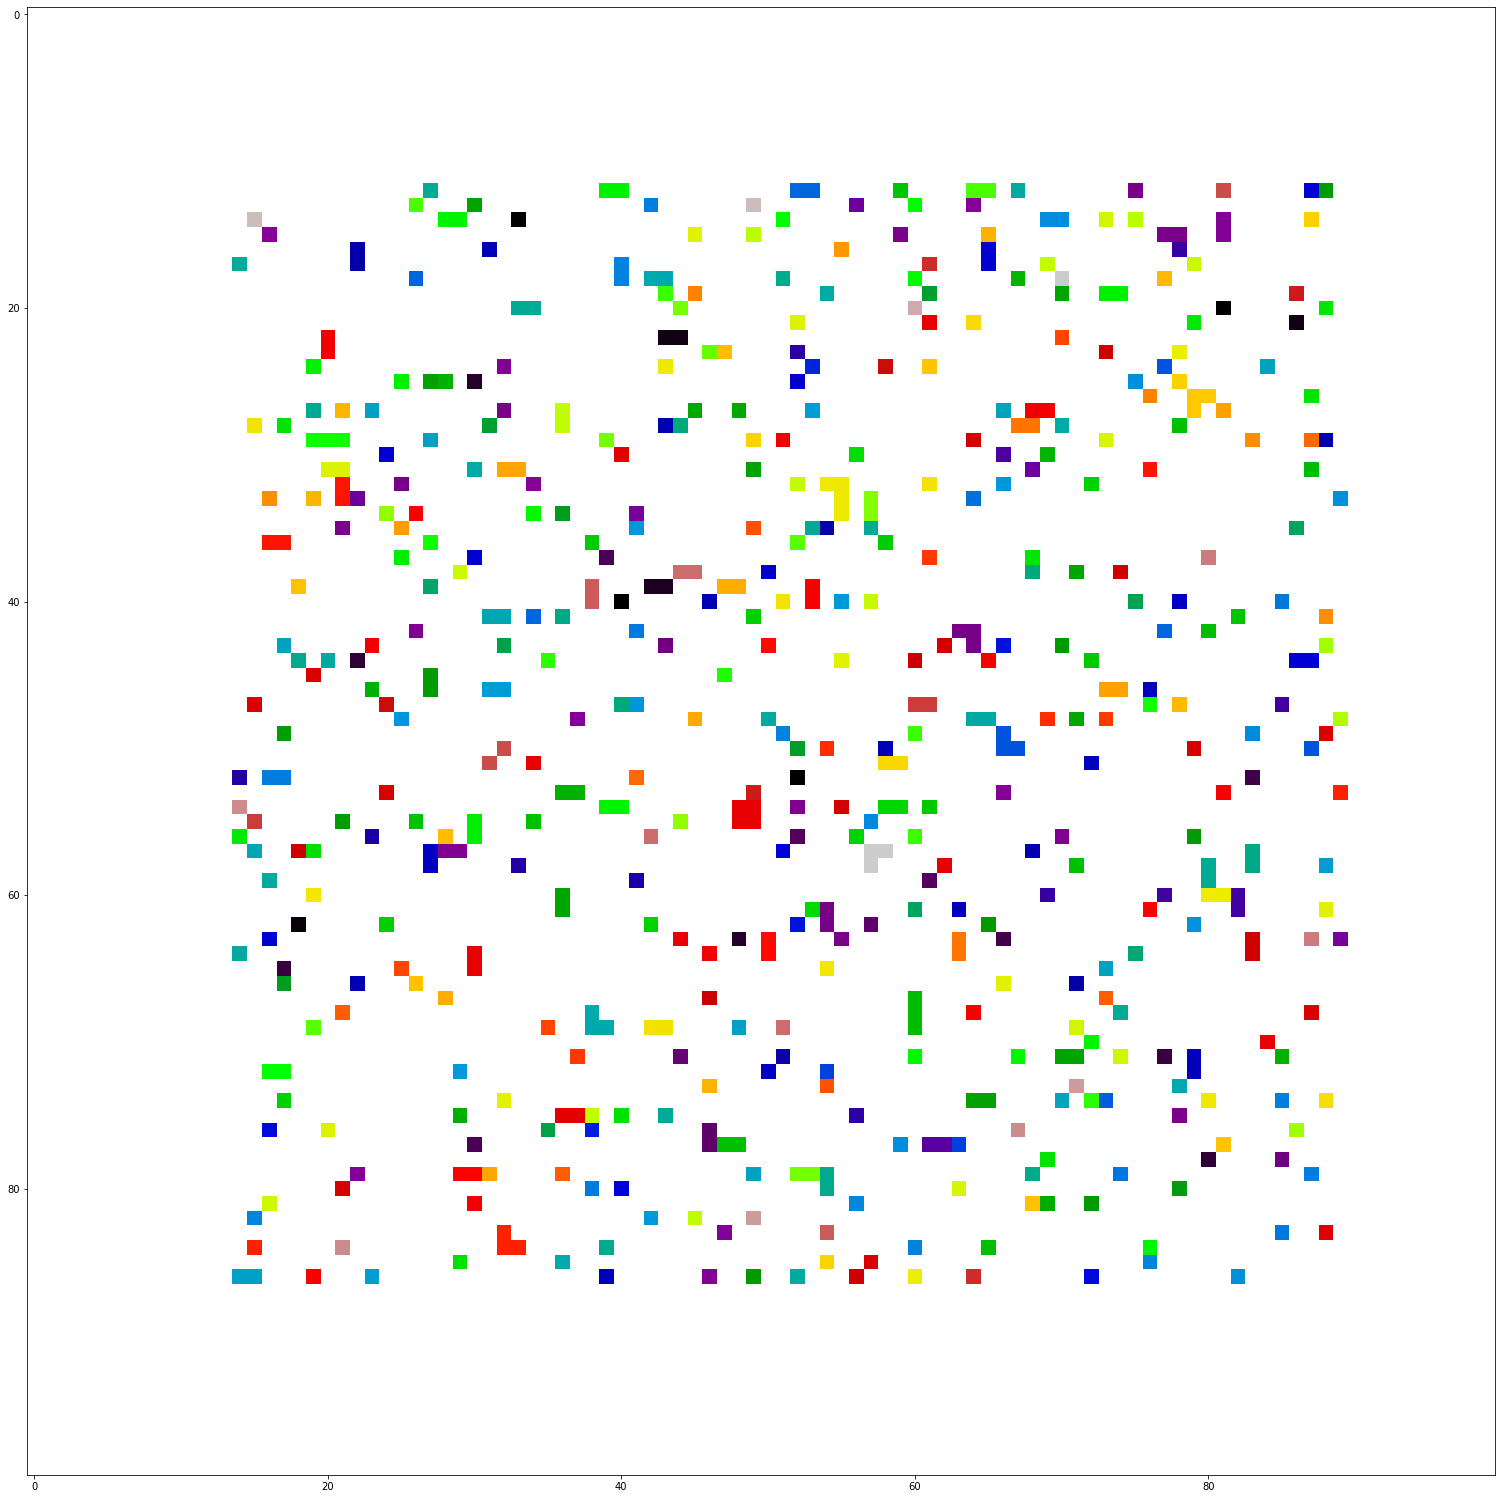

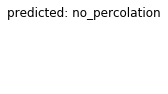

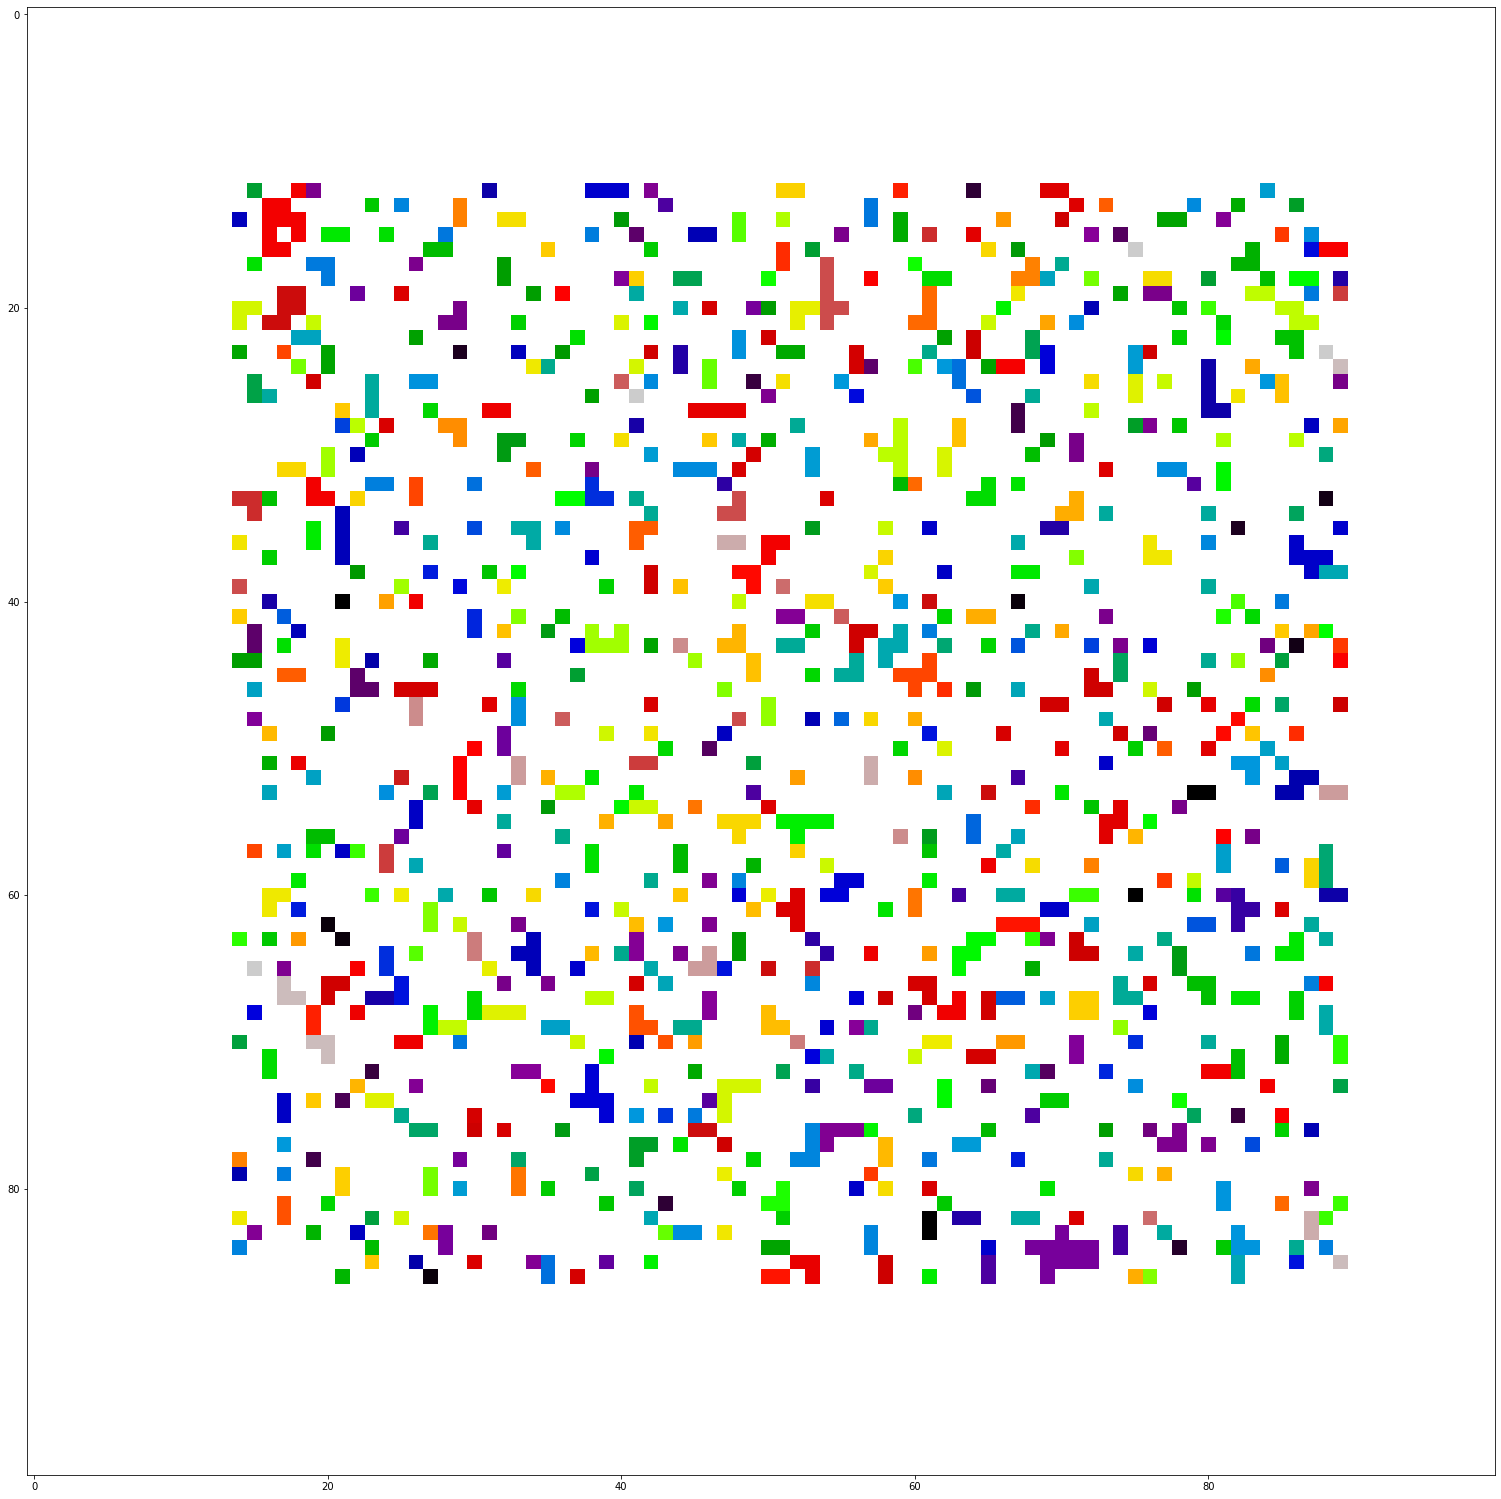

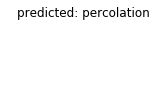

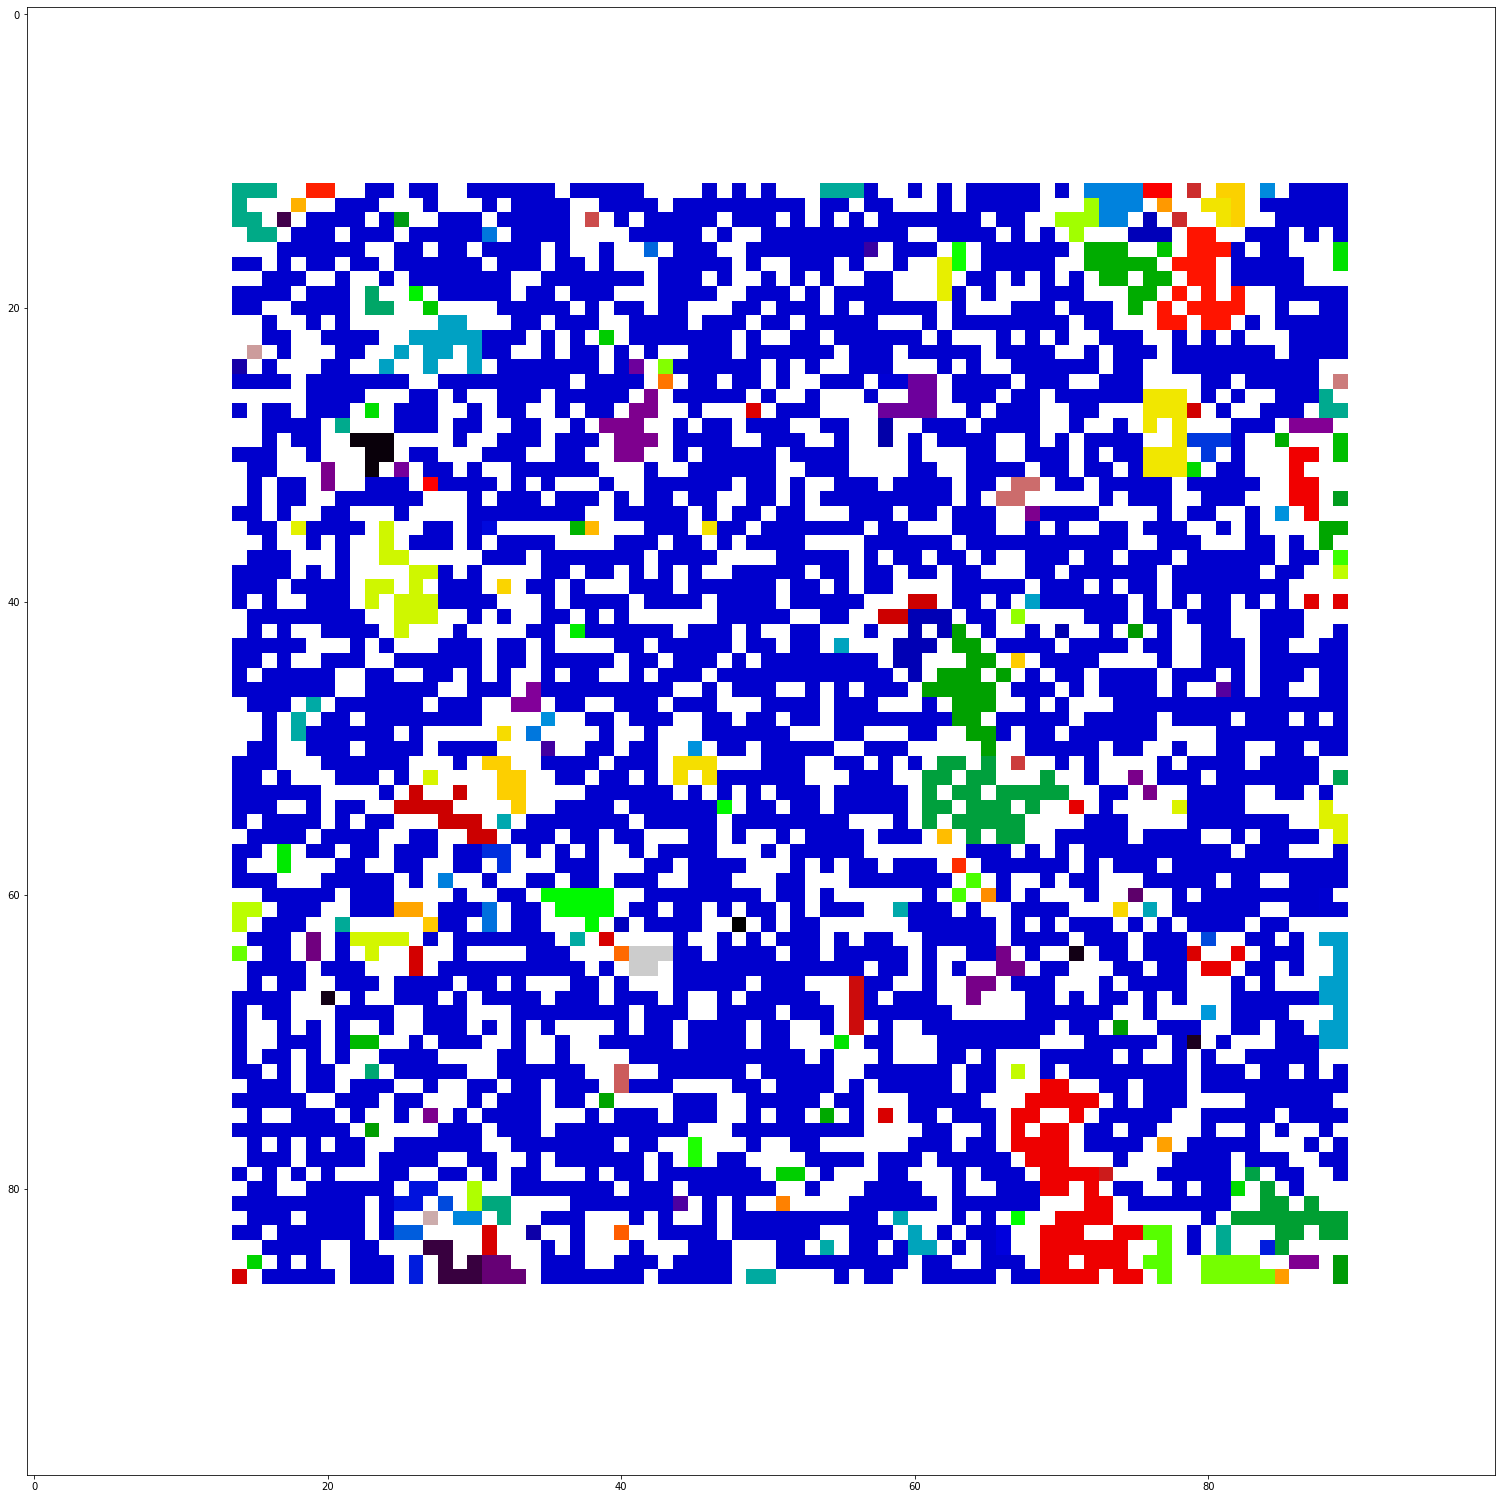

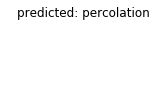

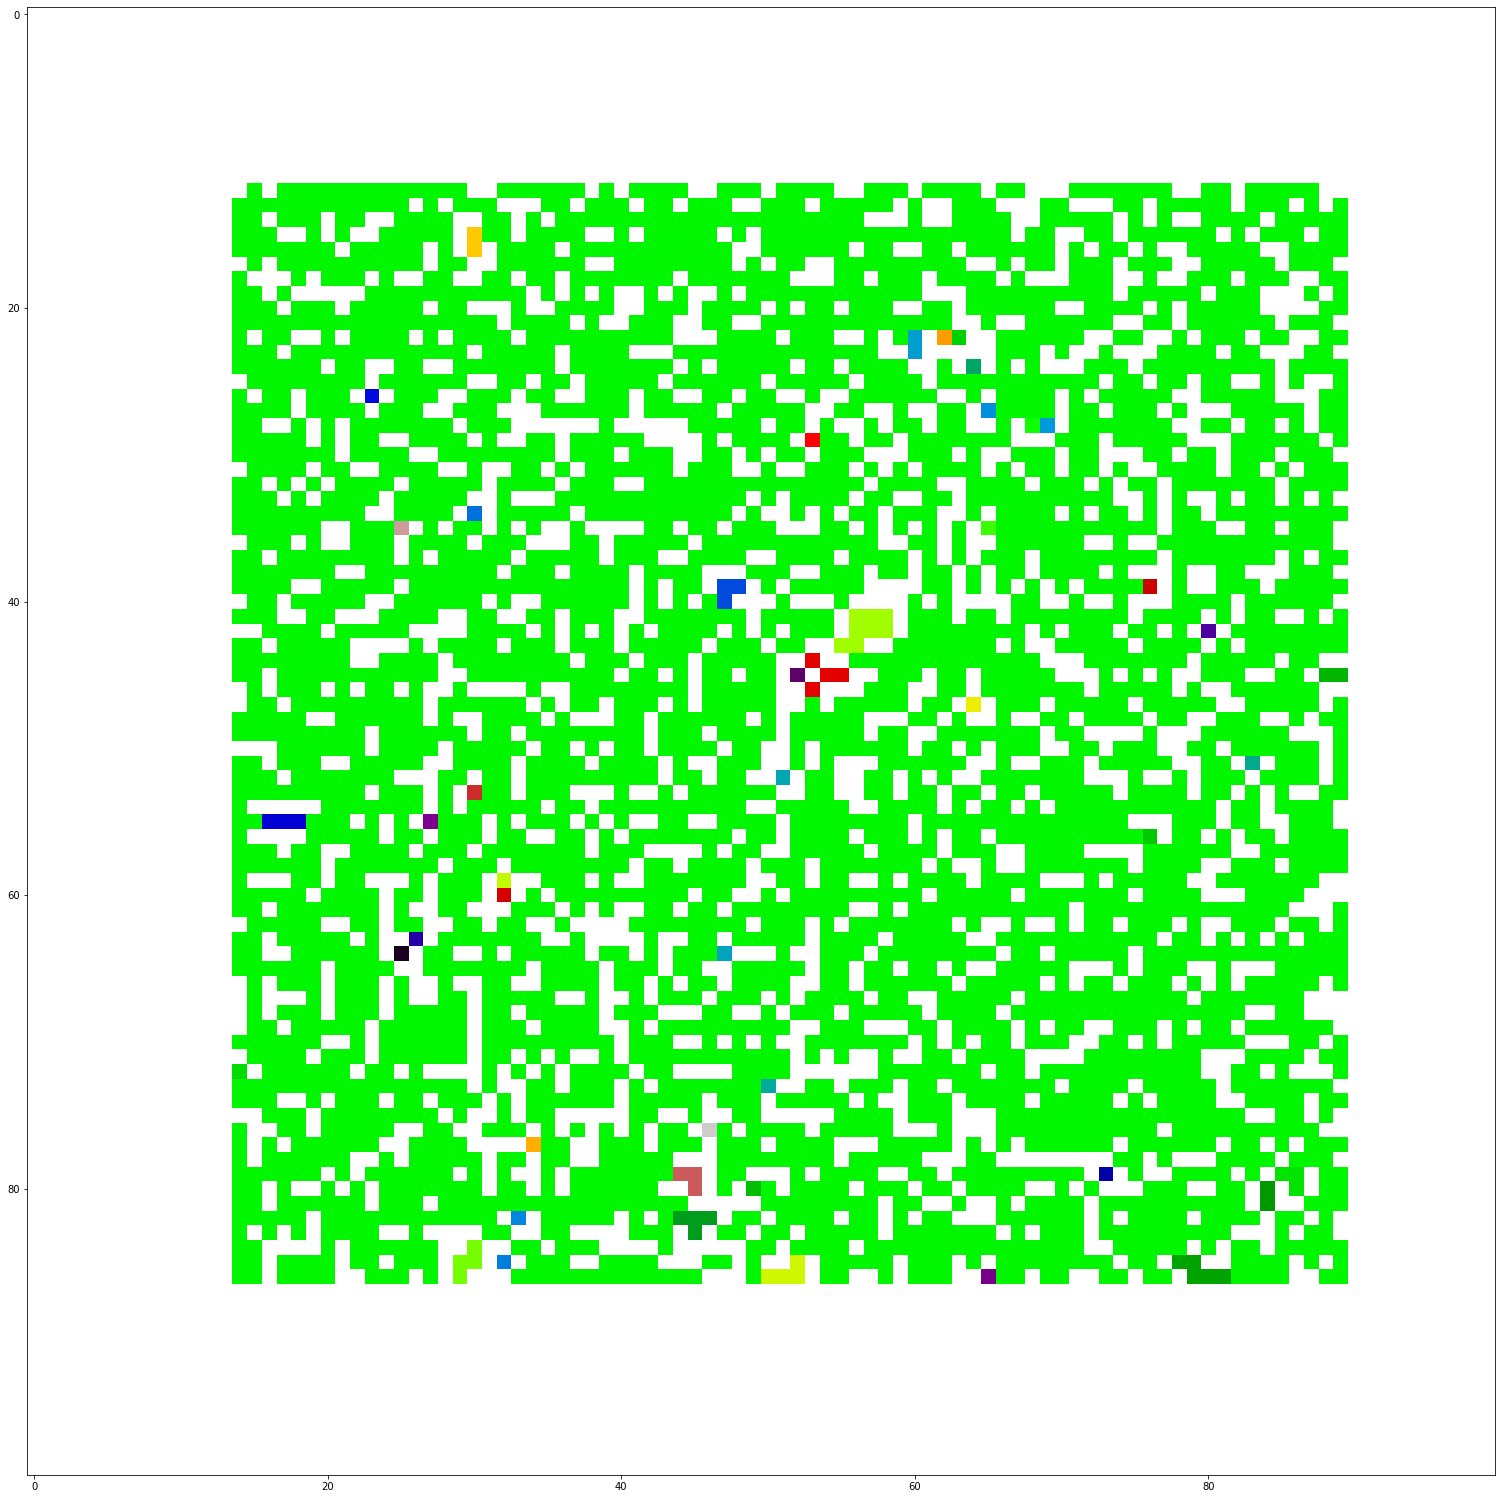

In [55]:
visualize_model(model1)

## testing the quality of the learned model

In [57]:
confusion_matrix = torch.zeros(number_classes, number_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(val):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model1(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[534.,  26.],
        [ 25., 415.]])
